# Grid price impact

In [1]:
import numba
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [2]:
%config InlineBackend.figure_format = "retina"

In [104]:
@njit
def sigmoid(z): return 1 / (1 + np.exp(-z))

@njit
def price_step(price, action, sigma, delta, price_impact):
    pr = sigmoid(action * price_impact)
    sign = np.random.uniform() > 1 - pr
    sign = 2 * sign - 1
    
    price_next = price + sigma * np.sqrt(delta) * sign
    price_next = np.maximum(0.0, price_next) # Minimum price is 0.0
    return price_next
    

@njit
def price_process(seed, num_steps, price_init, actions, sigma=1.0, delta=1.0, price_impact=1.0):
    """
    Price process when the actions are already known
    """
    np.random.seed(314)
    prices = np.zeros(num_steps)
    prices[0] = price_init
    for t in range(1, num_steps):
        prices[t] = price_step(prices[t-1], actions[t], sigma, delta, price_impact)
    return prices

### Example: buy at every step

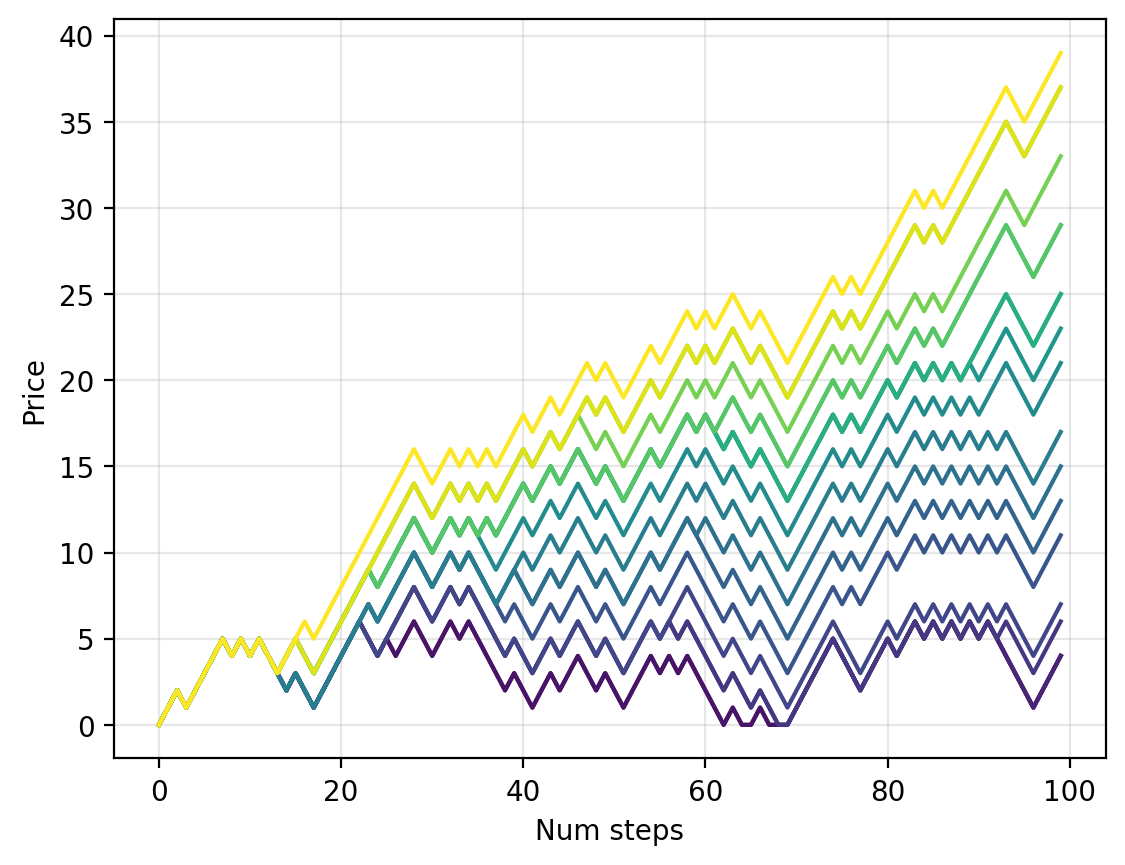

In [106]:
seed = 314
num_steps = 100
actions = np.ones(num_steps)

price_impacts = np.linspace(0, 1, 20)
colors = plt.cm.viridis(price_impacts)

for (price_impact, color) in zip(price_impacts, colors):
    prices = price_process(seed, num_steps, 0.0, actions, price_impact=price_impact)
    plt.plot(prices, c=color)

plt.xlabel("Num steps")
plt.ylabel("Price")
plt.grid(alpha=0.3)

## Value iteration

In [115]:
def bern_pmf(y, mu):
    return mu ** y * (1 - mu) ** (1 - mu)

In [119]:
def mdp(
    reward,
    price_next, inventory_next, cash_next, reward_next,
    price, inventory, cash, action,
    price_impact, temporary_price_impact, inventory_aversion
):
    """
    Markov decision process
    """
    p_action = sigmoid(action * price_impact)
    
    # Probability price transition
    side = price_next - price
    side = (side + 1) / 2
    pr_price = bern_pmf(side, p_action)
    
    # Probability inventory transition
    pr_inventory = (inventory_next == inventory + action)
    
    # probability cash transition
    pr_cash = (reward == cash - action * (price_next * inventory + temporary_price_impact * action))
    
    # Probability reward
    pr_reward = (reward == cash_next + inventory_next * price_next - inventory_aversion * inventory_next ** 2)
    
    pr = pr_price * pr_inventory * pr_cash * pr_reward
    return pr